> Our method

# import

In [1]:
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

import torch
import numpy as np
from tqdm import tqdm

import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

import matplotlib.pyplot as plt

In [2]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

# R

In [3]:
%load_ext rpy2.ipython

In [5]:
%%R
library(GNAR)
library(igraph)

## EbayesThresh

In [155]:
%%R
library(EbayesThresh)
set.seed(1)
epsilon = rnorm(1000)
signal = sample(c(runif(25,-2,-1.5), runif(25,1.5,2), rep(0,950)))
index_of_trueoutlier = which(signal!=0)
x_ebayes=signal+epsilon

In [156]:
%R -o x_ebayes
%R -o index_of_trueoutlier
%R -o signal

In [157]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [158]:
outlier_true_index = index_of_trueoutlier

In [159]:
outlier_true_value = x_ebayes[index_of_trueoutlier]

In [160]:
outlier_true_one = signal.copy()

In [161]:
outlier_true_one = list(map(lambda x: -1 if x!=0 else 1,outlier_true_one))

# 데이터 가정

데이터가정: missing (결측값) 이 있는 자료를 가정 

- missing이 있는상태: ST-GCN 을 사용할 수 X $\to$ **코드에 에러는 나지 않지만 yhat이 산출되지 않았습니다.**
- missing이 없어야만: ST-GCN 을 사용할 수 O 

**증명**

In [6]:
%%R
summary(fiveNet)

GNARnet with 5 nodes and 10 edges
 of equal length  1

In [7]:
%%R
edges <- as.matrix(fiveNet)
data("fiveNode")

In [8]:
%R -o fiveVTS
%R -o edges

- node: 5
- time 200

In [9]:
edges_tensor = torch.tensor(edges)

In [10]:
nonzero_indices = edges_tensor.nonzero()

In [11]:
fiveNet_edge = np.array(nonzero_indices).T

**데이터 일부 missing 처리**

In [12]:
%%R
fiveVTS0 <- fiveVTS
fiveVTS0[50:150, 3] <- NA

In [15]:
%R -o fiveVTS0

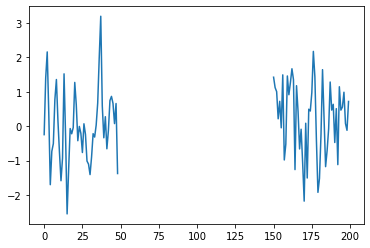

In [16]:
plt.plot(fiveVTS0[:,2])

In [17]:
fiveVTS0.shape

(200, 5)

In [18]:
T = 200
N = 5 # number of Nodes
E = fiveNet_edge
V = np.array([1,2,3,4,5])
t = np.arange(0,T)
node_features = 1

In [19]:
f = torch.tensor(fiveVTS0).reshape(200,5,1).float()

In [20]:
X = f[:199,:,:]
y = f[1:,:,:]

In [21]:
edge_index = torch.tensor(E)
edge_attr = torch.tensor(np.array([1,1,1,1,1,1,1,1,1,1]),dtype=torch.float32)

In [22]:
_ee = enumerate(zip(X,y))

In [23]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X,y)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


In [24]:
yhat = torch.stack([model(xt, edge_index, edge_attr) for xt in X]).detach().numpy()

In [25]:
yhat.shape

(199, 5, 1)

Result

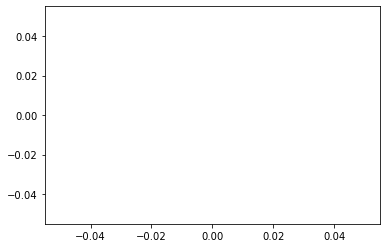

In [26]:
plt.plot(yhat[:,2].data)

# 1. missing을 채움. (mean, linear interpolation) 

## 1.1. Mean

In [132]:
fiveVTS0_mean = fiveVTS0.copy()

In [133]:
fiveVTS0_mean[49:150,2] = np.mean(fiveVTS0[:49,2].tolist()+fiveVTS0[150:,2].tolist())

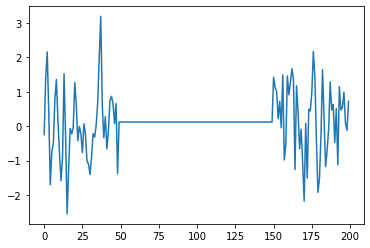

In [134]:
plt.plot(fiveVTS0_mean[:,2])

## 1.2. linear interpolation

In [144]:
# Define the two data points
x0, y0 = torch.tensor([48.0]), torch.tensor(fiveVTS0[48,2])
x1, y1 = torch.tensor([150.0]), torch.tensor(fiveVTS0[150,2])

# Define the target x value
x = torch.tensor([range(49,150)])

# Find the slope of the line between the two data points
m = (y1 - y0) / (x1 - x0)

# Use the slope and the coordinates of one of the data points to find the y-intercept
b = y0 - m * x0

# Use the slope and y-intercept to calculate the target y value
y = m * x + b
print(y)
y.shape

tensor([[-1.3480, -1.3206, -1.2931, -1.2657, -1.2382, -1.2108, -1.1833, -1.1558,
         -1.1284, -1.1009, -1.0735, -1.0460, -1.0186, -0.9911, -0.9636, -0.9362,
         -0.9087, -0.8813, -0.8538, -0.8264, -0.7989, -0.7714, -0.7440, -0.7165,
         -0.6891, -0.6616, -0.6342, -0.6067, -0.5792, -0.5518, -0.5243, -0.4969,
         -0.4694, -0.4420, -0.4145, -0.3871, -0.3596, -0.3321, -0.3047, -0.2772,
         -0.2498, -0.2223, -0.1949, -0.1674, -0.1399, -0.1125, -0.0850, -0.0576,
         -0.0301, -0.0027,  0.0248,  0.0523,  0.0797,  0.1072,  0.1346,  0.1621,
          0.1895,  0.2170,  0.2445,  0.2719,  0.2994,  0.3268,  0.3543,  0.3817,
          0.4092,  0.4367,  0.4641,  0.4916,  0.5190,  0.5465,  0.5739,  0.6014,
          0.6289,  0.6563,  0.6838,  0.7112,  0.7387,  0.7661,  0.7936,  0.8211,
          0.8485,  0.8760,  0.9034,  0.9309,  0.9583,  0.9858,  1.0133,  1.0407,
          1.0682,  1.0956,  1.1231,  1.1505,  1.1780,  1.2055,  1.2329,  1.2604,
          1.2878,  1.3153,  

torch.Size([1, 101])

In [145]:
fiveVTS0_linearinterpolation = fiveVTS0.copy()

In [146]:
fiveVTS0_linearinterpolation[49:150,2] = y

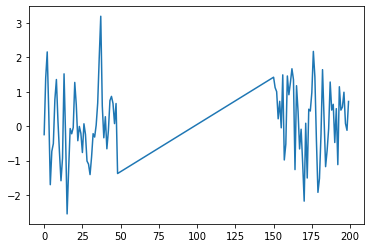

In [147]:
plt.plot(fiveVTS0_linearinterpolation[:,2])

# 2. ST-GCN 을 사용하여 fhat을 구함. (스무딩1) 

In [135]:
T = 200
N = 5 # number of Nodes
E = fiveNet_edge
V = np.array([1,2,3,4,5])
t = np.arange(0,T)
node_features = 1

In [136]:
edge_index = torch.tensor(E)
edge_attr = torch.tensor(np.array([1,1,1,1,1,1,1,1,1,1]),dtype=torch.float32)

## 2.1. Mean

In [137]:
f_mean = torch.tensor(fiveVTS0_mean).reshape(200,5,1).float()

In [138]:
X_mean = f_mean[:199,:,:]
y_mean = f_mean[1:,:,:]

In [139]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X_mean,y_mean)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


In [140]:
fhat_mean = torch.stack([model(xt, edge_index, edge_attr) for xt in X_mean]).detach().numpy()

In [141]:
fhat_mean.shape

(199, 5, 1)

Result

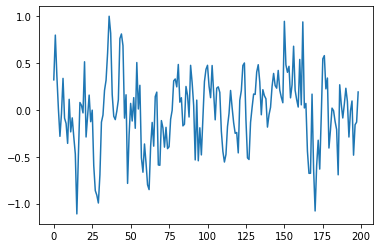

In [142]:
plt.plot(fhat_mean[:,2].data)

## 2.2. linear interpolation

In [148]:
f_linearinterpolation = torch.tensor(fiveVTS0_linearinterpolation).reshape(200,5,1).float()

In [149]:
X_linearinterpolation = f_mean[:199,:,:]
y_linearinterpolation = f_mean[1:,:,:]

In [150]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X_linearinterpolation,y_linearinterpolation)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


In [151]:
fhat_linearinterpolation = torch.stack([model(xt, edge_index, edge_attr) for xt in X_linearinterpolation]).detach().numpy()

In [152]:
fhat_linearinterpolation.shape

(199, 5, 1)

Result

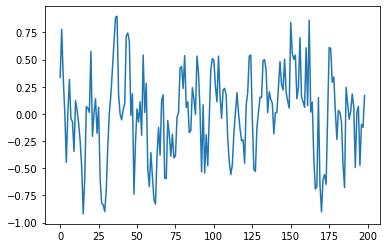

In [153]:
plt.plot(fhat_linearinterpolation[:,2].data)

# 3. 2에서 얻은 fhat을 이용하여 그래프퓨리에변환+Ebayesthresh (스무딩2)  

- 그래프퓨리에변환을 하는 가중치
- 년도끼리 이어주어서 하나의 큰 그래프로 만든뒤에 GFT 
- Ebayesthresh 

## 3.1. Mean

## 3.2.linear interpolation